# Семинар 7: Parameter-Efficient Fine-tuning

В этом семинаре мы попробуем дообучить модель GPT2-small на задачу анализа тональности с помощью различных методов PEFT:
1. LoRa – Low-Rank Adaptation
1. Prompt tuning
1. PEFT + LP-FT

## Датасет

Для оценки качества дообучения мы будем использовать один из датасетов бенчмарка GLUE, [SST2](https://huggingface.co/datasets/sst2) (Stanford Sentiment Treebank). Датасет содержит 67 тысяч предложений с отзывами на фильмы, которые требуется классифицировать на положительные и отрицательные.

In [1]:
import torch
from torch import nn
import subprocess
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "sst2", split='train[:50000]')
valid_dataset = load_dataset("glue", "sst2", split="validation")

Found cached dataset glue (/home/amshabalin/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Found cached dataset glue (/home/amshabalin/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [3]:
train_dataset[0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

In [4]:
train_dataset[2]

{'sentence': 'that loves its characters and communicates something rather beautiful about human nature ',
 'label': 1,
 'idx': 2}

In [5]:
len(train_dataset), len(valid_dataset) 

(50000, 872)

### Инициализация токенизатора и модели

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [93]:
model_checkpoint = "gpt2"

In [94]:
# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [95]:
class Model(nn.Module):
    def __init__(self, tokenizer, num_classes=2):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_classes)
        self.model.resize_token_embeddings(len(tokenizer))
        self.config = self.model.config

    def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, *args, **kwargs):
        out = self.model.transformer(
            input_ids=input_ids, inputs_embeds=inputs_embeds, attention_mask=attention_mask
        ).last_hidden_state
        lens = attention_mask.sum(-1).cpu() - 1
        out = out[torch.arange(len(lens)), lens.to(torch.long)]
        return self.model.score(out)
    
    @property
    def device(self):
        return next(self.model.parameters()).device


num_classes = 2
model = Model(tokenizer, num_classes)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [96]:
sum(p.numel() for p in model.parameters())

774033920

### Проверка токенизатора

In [16]:
# Running tokenizer on sample data
tokenizer(train_dataset[0]["sentence"])

{'input_ids': [24717, 649, 3200, 507, 422, 262, 21694, 4991, 220], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [19]:
from torch.utils.data import DataLoader

In [20]:
batch_size = 128
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, num_workers=2)

In [21]:
import numpy as np

# Percentage of classes in dataset

print("       0       1")
classes = [t["label"] for t in train_dataset]
print(f"Train: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

classes = [t["label"] for t in valid_dataset]
print(f"Valid: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

       0       1
Train: 0.442 0.558
Valid: 0.491 0.509


### Объявление функции для обучения моделей

In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics.functional import accuracy
from torch.optim import AdamW
import seaborn as sns

sns.set_theme()

In [30]:
_ = model.to(device)

In [29]:
def training_loop_fn(model, opt, total_num_iters, eval_freq, train_loader, valid_loader):
    train_loss_history, eval_loss_history = [], []
    train_acc_history, eval_acc_history = [], []
    global_step = 0

    criterion = torch.nn.CrossEntropyLoss()
    model.train()
    while True:
        for batch in tqdm(train_loader):
            tokenized = tokenizer(batch["sentence"], padding=True, return_tensors='pt')
            for k, v in tokenized.items():
                tokenized[k] = v.to(device)
            
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)
            targets = batch["label"].to(device)
            loss = criterion(logits, targets)

            opt.zero_grad()
            loss.backward()
            opt.step()

            preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]
            acc = accuracy(preds, targets)
    
            train_loss_history.append((global_step, loss.item()))
            train_acc_history.append((global_step, acc.item()))
    
            if global_step % eval_freq == 0:
                val_loss, val_acc = evaluate(model, valid_loader)
                eval_loss_history.append((global_step, val_loss))
                eval_acc_history.append((global_step, val_acc))
                                         
                model.train()

            if global_step % 250 == 0:
                clear_output(True)

                plt.figure(figsize=(15, 5))

                plt.subplot(121)
                plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                if len(eval_loss_history):
                    plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                plt.legend()    
                
                plt.subplot(122)
                plt.plot(*zip(*train_acc_history), alpha=0.5, label='train_acc')
                if len(eval_acc_history):
                    plt.plot(*zip(*eval_acc_history), color='red', label='eval_acc')
                plt.legend()
                plt.show()

            global_step += 1
            if global_step > total_num_iters:
                break
        else:
            continue
        break 


@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for eval_batch in dataloader:
        tokenized = tokenizer(eval_batch["sentence"], padding=True, return_tensors='pt')
        for k, v in tokenized.items():
            tokenized[k] = v.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)

        loss = criterion(logits, eval_batch["label"].to(device))
        num = logits.shape[0]

        loss_epoch += loss.item() * num
        num_epoch += num
        preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]

        targets_list += eval_batch["label"].tolist()
        preds_list += preds.tolist()

    acc = accuracy(torch.tensor(preds_list).to(device), torch.tensor(targets_list).to(device))

    return loss_epoch / num_epoch, acc.item()

## Fine-tuning

Обучаем все веса модели. Данный подход будет наиболее требовательным к памяти, однако он применяется чаще всего.

In [32]:
model = Model(tokenizer, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=2e-6)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


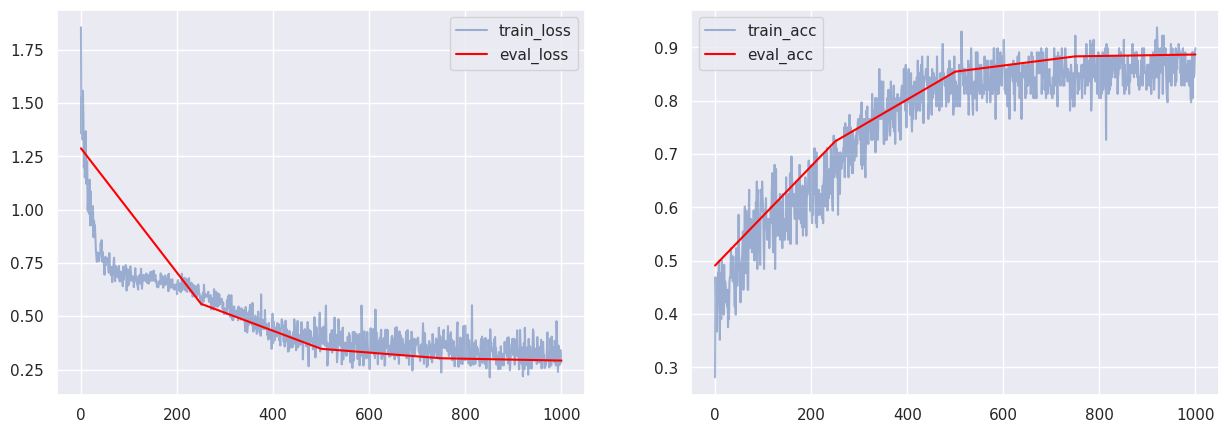

CPU times: user 1min 10s, sys: 18.5 s, total: 1min 28s
Wall time: 1min 47s


In [34]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [35]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.29211313790137616
val accuracy: 0.8864678740501404


## Linear Probing

Учим только последний линейный слой (голову) модели.

In [36]:
model = Model(tokenizer, num_classes).to(device)
optimizer = AdamW(model.model.score.parameters(), lr=1e-4)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


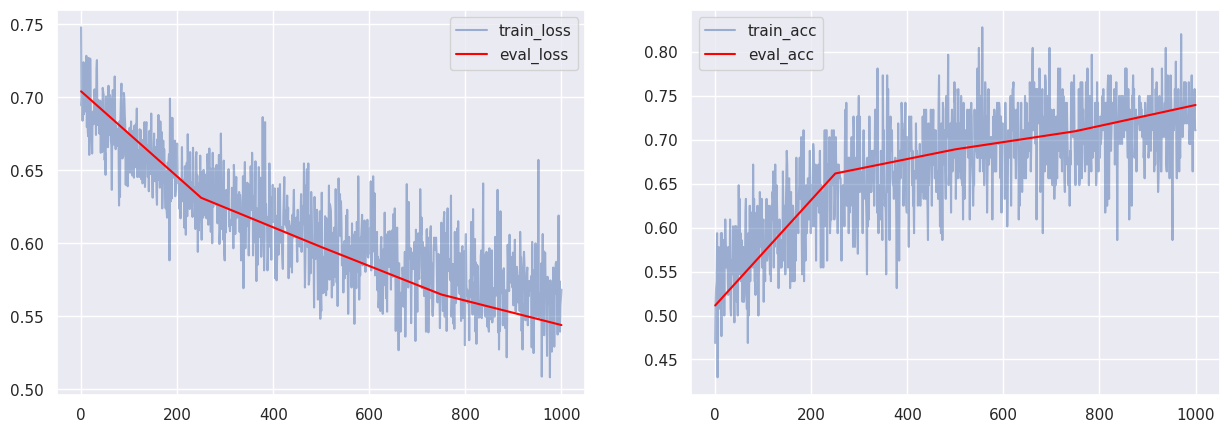

CPU times: user 1min 5s, sys: 16.5 s, total: 1min 21s
Wall time: 2min


In [37]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [38]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.5440841814793578
val accuracy: 0.7396789193153381


## LoRa

В оригинальной статье авторы предлагают учить только матрицы $W_K$ и $W_V$ в слоях внимания трансформера и последний линейный слой. Однако мы добавим к ним еще матрицу $W_Q$, потому что в архитектуре GPT все три матрицы считаются с помощью одного слоя, и разделять их было бы слишком неудобно.

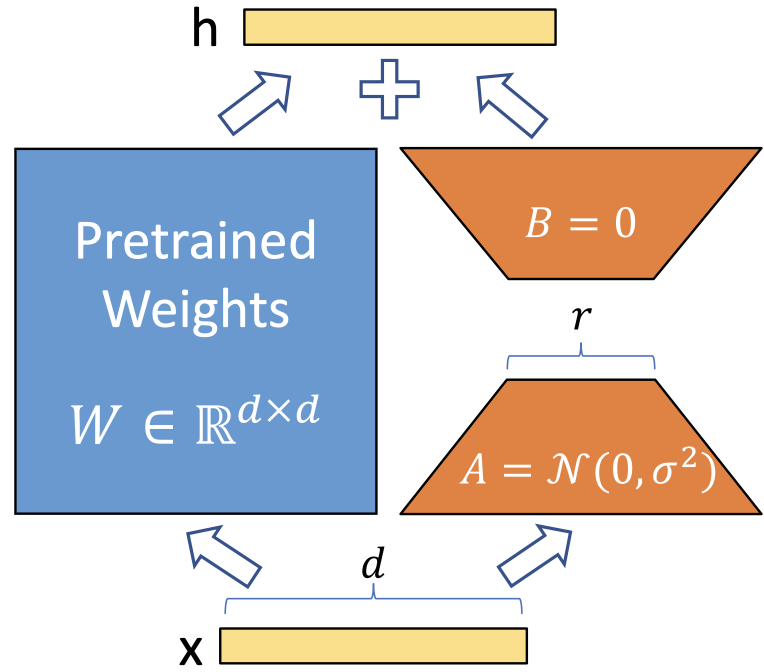

Для реализации Parameter-Efficient Fine-Tuning мы будем пользоваться библиотекой `peft` (семейство huggingface). В ней реализованы многие наиболее удачные способы дообучения моделей. Полный список можно найти [тут](https://github.com/huggingface/peft).

Самый важный параметр этой модели – ранг матриц $A$ и $B$ ($r$). Его увеличение дает больше степеней свободы в настройке добавки $AB$, повышая вместе с этим количество обучаемых параметров.

In [50]:
from peft import get_peft_model, LoraConfig, TaskType

In [60]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_dropout=0.1, target_modules=['c_attn']
)

model = Model(tokenizer, num_classes).to(device)
lora_model = get_peft_model(model, peft_config).to(device)
lora_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 296,448 || all params: 124,738,560 || trainable%: 0.23765546115010466


In [61]:
sum(p.numel() for p in lora_model.parameters() if p.requires_grad)

296448

In [62]:
optimizer = AdamW(lora_model.parameters(), lr=1e-4)

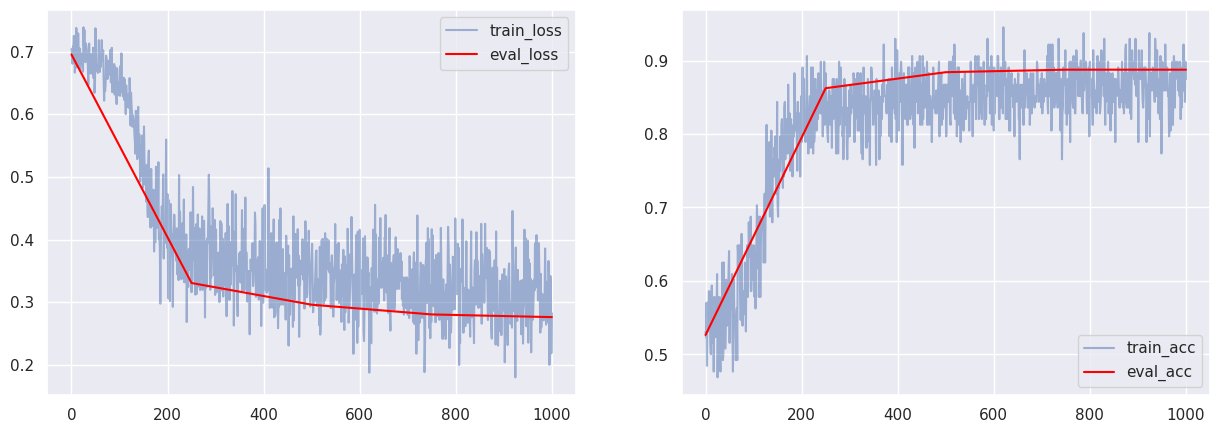

CPU times: user 1min 9s, sys: 15 s, total: 1min 24s
Wall time: 2min 3s


In [63]:
%%time
training_loop_fn(lora_model, optimizer, 1000, 250, train_loader, valid_loader)

In [64]:
val_loss, val_acc = evaluate(lora_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.27614544509747707
val accuracy: 0.8876146674156189


In [70]:
torch.save(lora_model.base_model.model.model.score.state_dict(), 'lora_head.pt')

## Prompt Tuning

Prompt Tuning – наиболее архитектурно-зависимый способ дообучения моделей, так как основан на наблюдении о том, что большие языковые модели способны решать задачи в zero-shot и few-shot парадигме (то есть опираясь только на входной промпт и текст, для которого нужно выдать ответ). Для моделей, которые могут работать в таком формате Prompt Tuning предлагает не выбирать промпт руками, а обучить его. Таким образом, этот метод лучше всего будет работать с моделями вида GPT и хуже всего с BERT. Вместе с промптом дополнительно доучивается голова.

<!-- 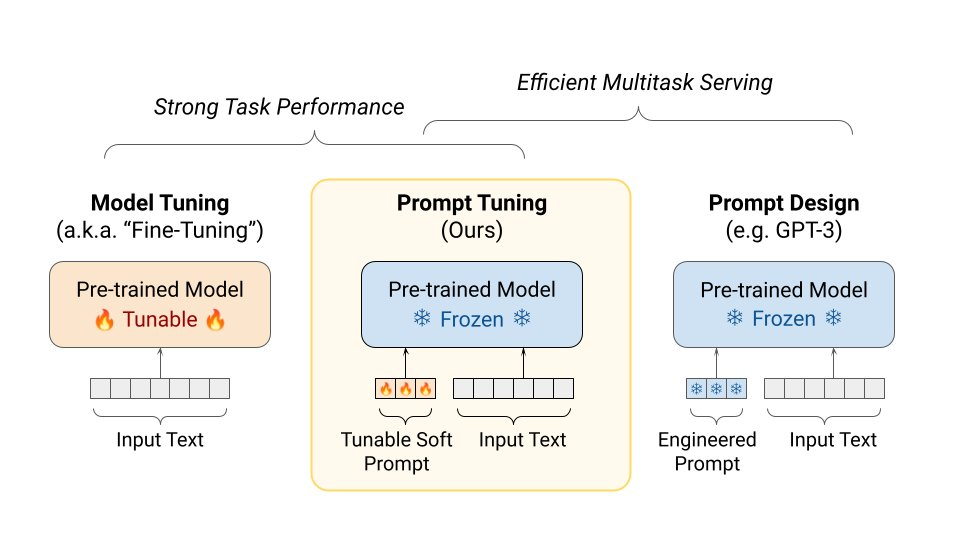 -->
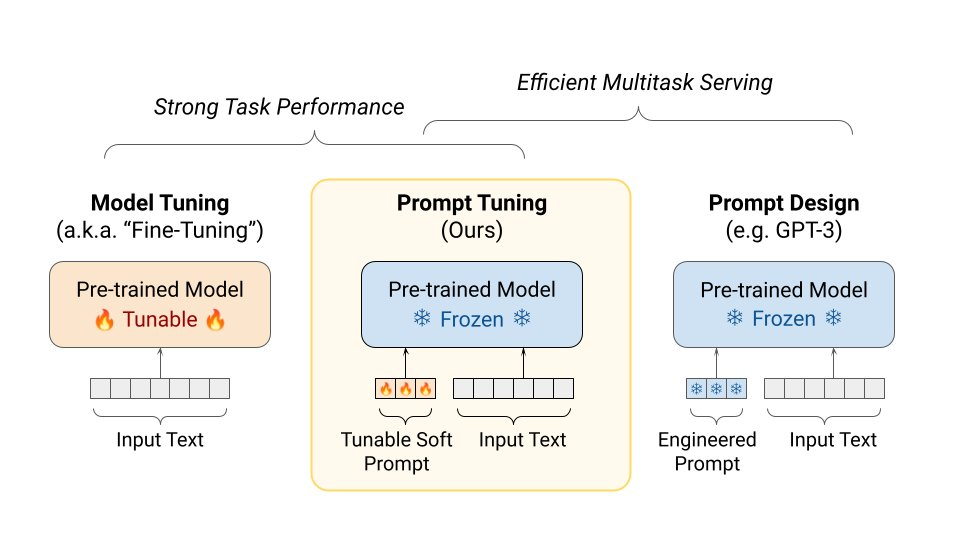


При настройке промпта можно варьировать его длину, а так же способ инициализации. Тут работает правило: чем больше датасет для дообучения, тем длинее можно брать промпты. Если датасет маленький, то длиный промпт не сможет обучиться.

In [44]:
from peft import PromptTuningConfig, PromptTuningInit

In [ ]:
len(tokenizer("Predict if sentiment of this review is positive or negative")['input_ids'])

11

In [98]:
init = {PromptTuningInit.TEXT: "Predict if sentiment of this review is positive or negative"}

In [ ]:
config = model.config
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, num_virtual_tokens=12,
    num_layers=config.n_layer, token_dim=config.n_embd, num_attention_heads=config.n_head,
    prompt_tuning_init=init
)

model = Model(tokenizer, num_classes).to(device)
pt_model = get_peft_model(model, peft_config).to(device)
pt_model.print_trainable_parameters()

In [100]:
optimizer = AdamW(pt_model.parameters(), lr=1e-4)

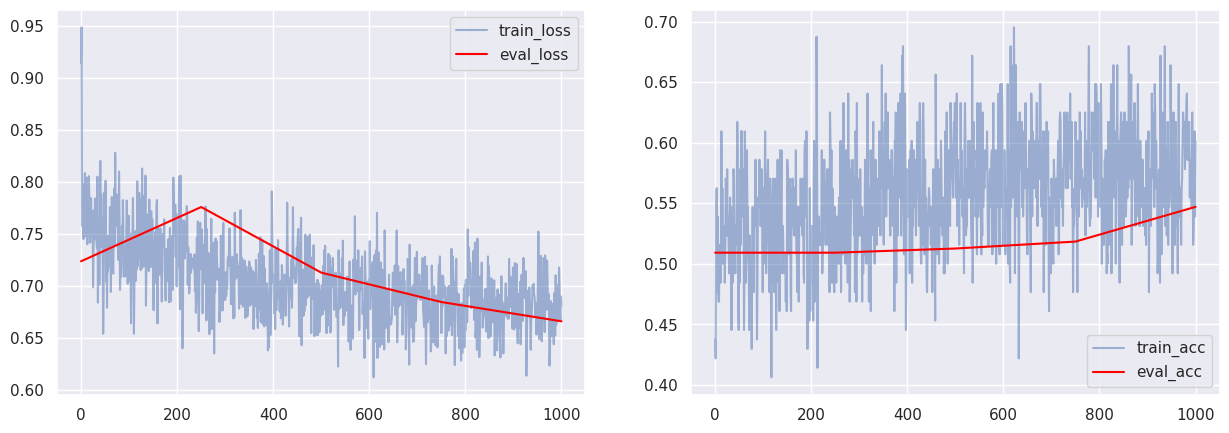

CPU times: user 4min 21s, sys: 2min 11s, total: 6min 32s
Wall time: 6min 52s


In [101]:
%%time
training_loop_fn(pt_model, optimizer, 1000, 250, train_loader, valid_loader)

In [48]:
val_loss, val_accuracy = evaluate(pt_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val acc: {val_accuracy}')

val loss: 0.63037109375
val acc: 0.6743119359016418


## LP-FT

In [83]:
chkpt = torch.load('lora_head.pt')
chkpt.keys()

odict_keys(['original_module.weight', 'modules_to_save.default.weight'])

In [84]:
model = Model(tokenizer, num_classes).to(device)
model.model.score.load_state_dict({
    'weight': torch.load('lora_head.pt')['modules_to_save.default.weight']
})
optimizer = AdamW(model.parameters(), lr=2e-6)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


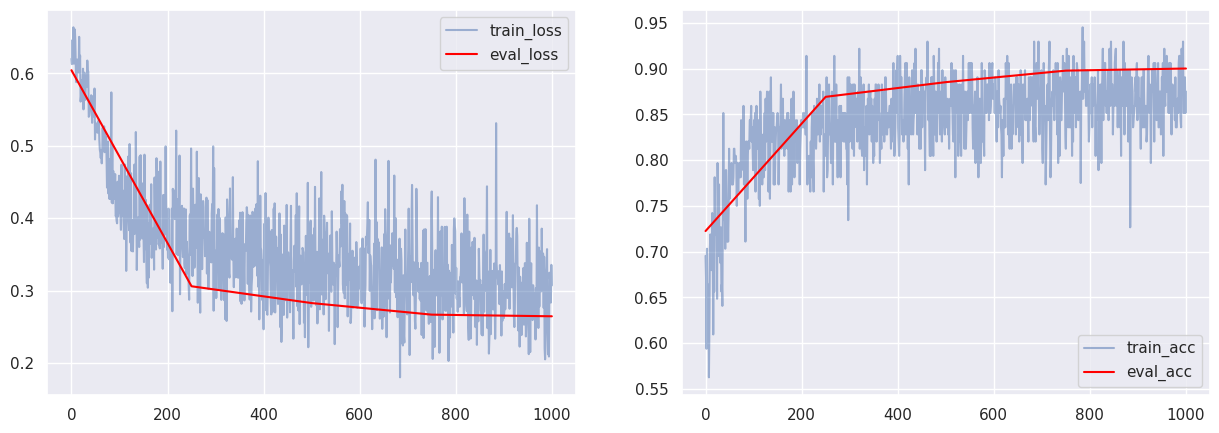

CPU times: user 1min 12s, sys: 17.7 s, total: 1min 30s
Wall time: 2min 29s


In [85]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [86]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.26476490825688076
val accuracy: 0.9002293348312378


### Testing the model

In [87]:
@torch.no_grad()
def predict(text, target=0):
    tokenized = tokenizer(text, return_tensors='pt')
    for k, v in tokenized.items():
        tokenized[k] = v.to(device)

    logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)
    probs = torch.nn.functional.softmax(logits, dim=-1)

    predicted_class_id = int(torch.argmax(logits, dim=-1))
    print(f"text: {text}")
    print(f"target: {target}, pred: {predicted_class_id}")
    print("probs:", probs.cpu().numpy())

In [88]:
predict("this movie is amaizing", 1)

text: this movie is amaizing
target: 1, pred: 0
probs: [[0.6141767  0.38582337]]


In [89]:
for i in range(10):
    text = valid_dataset[i]["sentence"]
    label = valid_dataset[i]["label"]
    predict(text, label)
    print()

text: it 's a charming and often affecting journey . 
target: 1, pred: 1
probs: [[0.00181885 0.9981812 ]]

text: unflinchingly bleak and desperate 
target: 0, pred: 0
probs: [[0.88542634 0.11457368]]

text: allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . 
target: 1, pred: 1
probs: [[0.02235406 0.97764593]]

text: the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . 
target: 1, pred: 1
probs: [[0.01311396 0.986886  ]]

text: it 's slow -- very , very slow . 
target: 0, pred: 0
probs: [[0.9754901  0.02450995]]

text: although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . 
target: 1, pred: 1
probs: [[0.01288734 0.9871127 ]]

text: a sometimes tedious film . 
target: 0, pred: 0
probs: [[0.9744402  0.02555974]]

text: or doing last year 's taxes with your ex-wife . 
target: 0, pred: 0
probs: [[0.80908567 0.1909143